In [2]:
import sys
sys.path.append("..")

import json
import numpy as np

In [3]:
def get_results(filename):
    with open(filename, "r") as f:
        data = json.load(f)
    #print("Number of data points: ", len(data))
    return data

In [4]:
def get_test_data_annotations():
    visual_news_data = json.load(open("../../datasets/visualnews/origin/data.json"))
    visual_news_data_mapping = {ann["id"]: ann for ann in visual_news_data}

    test_data = json.load(open("../../news_clippings/news_clippings/data/merged_balanced/test.json"))
    annotations = test_data["annotations"]
    return annotations
test_data_annotations = get_test_data_annotations()
test_data_annotations = test_data_annotations[:1000]

In [5]:
def fix_unsures(data):
    """
    In instances where one of the models does not have any output, consider the output of the other model to be the truth
    """
    num_unsures = 0
    for i in range(len(data)):
        if data[i]['falsified'] == "Unsure":
            num_unsures += 1
            if data[i]['output']['model_0'] == "" and data[i]['output']['model_1'] != "":
                if "YES" in data[i]['output']['model_1'] or "Yes" in data[i]['output']['model_1']:
                    data[i]['falsified'] = True
                elif "NO" in data[i]['output']['model_1'] or "No" in data[i]['output']['model_1']:
                    data[i]['falsified'] = False
            elif data[i]['output']['model_0'] != "" and data[i]['output']['model_1'] == "":
                if "YES" in data[i]['output']['model_0'] or "Yes" in data[i]['output']['model_0']:
                    data[i]['falsified'] = True
                elif "NO" in data[i]['output']['model_0'] or "No" in data[i]['output']['model_0']:
                    data[i]['falsified'] = False
    print("Num unsures: ", num_unsures)
    return data

In [6]:
def num_disagreements(data):
    """
    Function to check when models actually disagree and when they are just unsure
    """
    disagreements = 0
    for i in range(len(data)):
        m0 = data[i]['output']['model_0']
        m1 = data[i]['output']['model_1']
        if data[i]['falsified'] == "Unsure":
            #check if models disagree
            if ("YES" in m0 or "Yes" in m0) and ("NO" in m1 or "No" in m1 or "Unsure" in m1):
                disagreements += 1
            elif ("NO" in m0 or "No" in m0) and ("YES" in m1 or "Yes" in m1 or "Unsure" in m1):
                disagreements += 1
            elif "Unsure" in m0 and ("YES" in m1 or "NO" in m1 or "Yes" in m1 or "No" in m1):
                disagreements += 1
    print("Num disagreements: ", disagreements)

In [7]:
def get_accuracy(data, annotations):
    num_correct = 0
    data = fix_unsures(data)
    incorrect_idx = []
    for i in range(len(data)):
        if bool(data[i]['falsified']) == annotations[i]['falsified']:
            num_correct += 1
        else:
            incorrect_idx.append(i)
    print("Num incorrects: ", len(incorrect_idx))
    return num_correct/len(data)

In [8]:
def get_incorrect_idx(data, annotations):
    num_correct = 0
    data = fix_unsures(data)
    incorrect_idx = []
    for i in range(len(data)):
        if bool(data[i]['falsified']) != annotations[i]['falsified']:
            incorrect_idx.append(i)
    return incorrect_idx

In [9]:
def get_acc_without_unsures(data, annotations):
    num_correct, num_unsures = 0,0
    for i in range(len(data)):
        if data[i]['falsified'] == 'Unsure':
            num_unsures += 1
        elif bool(data[i]['falsified']) == annotations[i]['falsified']:
            num_correct += 1
    return num_correct/(len(data) - num_unsures)

In [10]:
def true_positives(data, annotations):
    num_tp = 0
    for i in range(len(data)):
        if annotations[i]['falsified'] == True and bool(data[i]['falsified']) == True:
            num_tp += 1
    return num_tp

In [11]:
def false_positives(data, annotations):
    num_fp = 0
    for i in range(len(data)):
        if annotations[i]['falsified'] == False and bool(data[i]['falsified']) == True:
            num_fp += 1
    return num_fp

In [12]:
def false_negatives(data, annotations):
    num_fn = 0
    for i in range(len(data)):
        if annotations[i]['falsified'] == True and bool(data[i]['falsified']) == False:
            num_fn += 1
    return num_fn

In [13]:
def get_precision_and_recall(data, annotations):
    tp,fp,fn = true_positives(data, annotations), false_positives(data, annotations), false_negatives(data, annotations)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return precision, recall

### no web access

In [180]:
no_web_file = "../results/results_no_web_access.json"
result_data = get_results(no_web_file)
result_data = result_data[:1000]
num_disagreements(result_data)
precision, recall = get_precision_and_recall(result_data, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data, test_data_annotations)))


Num disagreements:  4
Num unsures:  675
Num incorrects:  428
Accuracy: 0.5720
Precision: 0.5448
Recall: 0.8640
Accuracy without unsures: 0.7515


### with web access (only when model unsure)

In [38]:
web_access_file = "../results/results_web_access_no_initial_context.json"
result_data2 = get_results(web_access_file)
num_disagreements(result_data2)
precision, recall = get_precision_and_recall(result_data2, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data2, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data2, test_data_annotations)))

Num disagreements:  16
Num unsures:  329
Accuracy: 0.5960
Precision: 0.5804
Recall: 0.6860
Accuracy without unsures: 0.6433


In [41]:
web_access_file = "../results/results_initial_context.json"
result_data3 = get_results(web_access_file)
num_disagreements(result_data3)
precision, recall = get_precision_and_recall(result_data3, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data3, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data3, test_data_annotations)))

Num disagreements:  7
Num unsures:  9
Accuracy: 0.8580
Precision: 0.8266
Recall: 0.9060
Accuracy without unsures: 0.8587


### with disambiguation queries

In [16]:
web_access_file = "../results/results_with_disambiguation.json"
result_data4 = get_results(web_access_file)
num_disagreements(result_data4)
precision, recall = get_precision_and_recall(result_data4, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data4, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data4, test_data_annotations)))

Num disagreements:  5
Num unsures:  12
Accuracy: 0.7730
Precision: 0.7468
Recall: 0.8260
Accuracy without unsures: 0.7786


### with opposite stances and disambiguation queries

In [ ]:
web_access_file = "../scripts/temp_final_disamb.json"
result_data5 = get_results(web_access_file)
num_disagreements(result_data5)
precision, recall = get_precision_and_recall(result_data5, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data5, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data5, test_data_annotations)))

In [24]:
web_access_file = "../scripts/disamb_res_updated_1.json"
result_data5 = get_results(web_access_file)
print(len(result_data5))
num_disagreements(result_data5)
precision, recall = get_precision_and_recall(result_data5, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data5, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data5, test_data_annotations)))

253
Num disagreements:  1
Num unsures:  6
Accuracy: 0.7352
Precision: 0.7153
Recall: 0.7778
Accuracy without unsures: 0.7368


### actor-skeptic setup

In [15]:
web_access_file = "../results/results_actor_skeptic.json"
result_data6 = get_results(web_access_file)
print(len(result_data6))
#num_disagreements(result_data6)
precision, recall = get_precision_and_recall(result_data6, test_data_annotations)
#print("Accuracy: {:.4f}".format(get_accuracy(result_data6, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data6, test_data_annotations)))

1000
Precision: 0.6610
Recall: 0.6940
Accuracy without unsures: 0.6945


### Finetuned model results

In [18]:
web_access_file = "../results/results_finetuned.json"
result_data7 = get_results(web_access_file)
print(len(result_data7))
num_disagreements(result_data7)
precision, recall = get_precision_and_recall(result_data7, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data7, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data7, test_data_annotations)))

1000
Num disagreements:  8
Num unsures:  25
Num incorrects:  182
Accuracy: 0.8180
Precision: 0.7449
Recall: 0.9580
Accuracy without unsures: 0.8192


In [19]:
web_access_file = "../results/results_finetuned_debate_refined.json"
result_data7 = get_results(web_access_file)
print(len(result_data7))
num_disagreements(result_data7)
precision, recall = get_precision_and_recall(result_data7, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data7, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data7, test_data_annotations)))

1000
Num disagreements:  40
Num unsures:  234
Num incorrects:  451
Accuracy: 0.5490
Precision: 0.5180
Recall: 0.9500
Accuracy without unsures: 0.5912


### Debating with judge

In [13]:
def get_accuracy(data, annotations):
    num_correct = 0
    incorrect_idx = []
    for i in range(len(data)):
        if bool(data[i]['falsified']) == annotations[i]['falsified']:
            num_correct += 1
        else:
            incorrect_idx.append(i)
    print("Num incorrects: ", len(incorrect_idx))
    return num_correct/len(data)

In [19]:
web_access_file = "../scripts/dj_temp.json"
result_data7 = get_results(web_access_file)
print(len(result_data7))
#num_disagreements(result_data7)
precision, recall = get_precision_and_recall(result_data7, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data7, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data7, test_data_annotations)))

27
Num unsures:  0
Num incorrects:  9
Accuracy: 0.6667
Precision: 0.6667
Recall: 0.6154
Accuracy without unsures: 0.6667


### Analysing where model fails (what kinds of examples the model fails on)

In [15]:
from PIL import Image
from utils.data import get_data, show_data

In [16]:
def retrieve_summary(key):
    with open("../utils/summaries.json", "r") as f:
        data = json.load(f)
    return data[key]

In [17]:
def failed_samples(incorrect_idx, res_data):
    for i in incorrect_idx:
        img, caption, _, annotation = get_data(i)
        display(img)
        show_data(i)
        key = str(annotation['id'])+"_"+str(annotation['image_id'])
        print("Associated summary: ", retrieve_summary(key))
        print("Model_prediction: ", res_data[i]['falsified'])
        print("Model arguments: ", res_data[i]['output'])
        cont = input()
        if "exit" == cont:
            break

Num unsures:  0


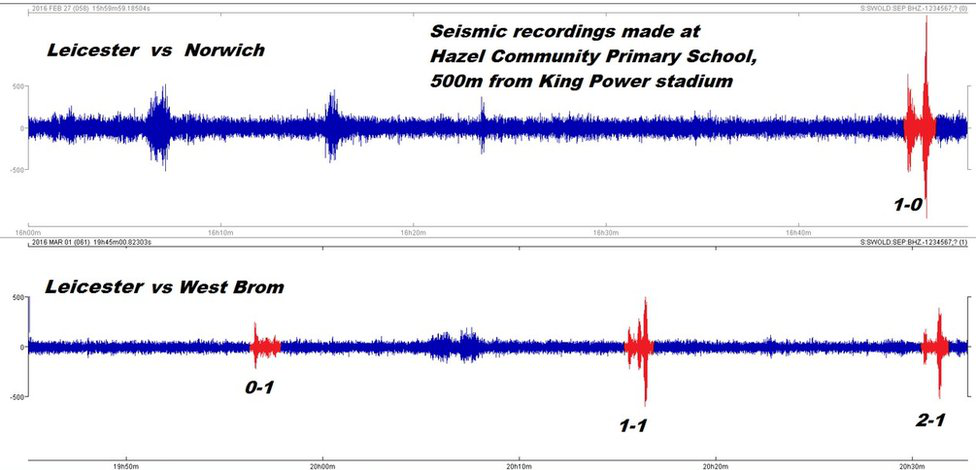

Caption:  Virginia Tech s Thor includes artificial elastic muscles It will not be ready until 2014 so will be replaced by a less advanced substitute at this stage
Misinformation (Ground Truth): True
Associated summary:  SUMMARY:
            
A minor earthquake with a magnitude of 0.3 was recorded in the UK for the first time, attributed to football fans celebrating a goal. The tremor was picked up by seismologists near Leicester City's King Power stadium during a match against Norwich in February. The event has been labeled the "Vardy Quake" after top scorer Jamie Vardy. Geology students at the University of Leicester installed seismic equipment near the stadium and recorded a spike in seismic activity when Leicester scored. The phenomenon is being studied to determine which player will generate the biggest seismic signal. Leicester City is currently leading the Premier League with a five-point advantage.
Model_prediction:  False
Model arguments:  DEBATER-A:
The image-caption pair is n

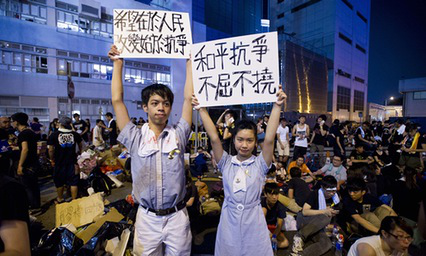

Caption:  Passengers are stranded outside the Guangzhou railway station in China s Guangdong province on Tuesday
Misinformation (Ground Truth): True
Associated summary:  SUMMARY:
            
            The recent protests in Hong Kong have highlighted the differences between the region and mainland China. Hong Kong has a separate legal system, economy, and political system than mainland China. The region has a long tradition of public protest and a commitment to democratic freedom, which has been met with Beijing's intervention and repression. The key sticking points in Hong Kong politics include the democratic transition, Beijing's intervention, and the erosion of autonomy.

Please let me know if you'd like me to make any changes.
Model_prediction:  False
Model arguments:  DEBATER-A:The image-caption pair is not misinformation. The image shows a protest in Hong Kong, where people are holding signs with Chinese characters. The caption accurately describes the scene as a protest outsi

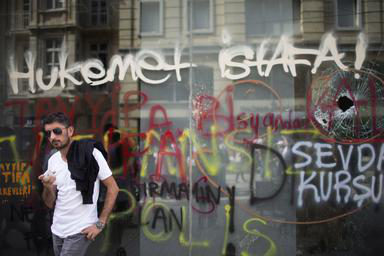

Caption:  A Turkish man stands next to a bank window that was damaged during riots after antigovernment demonstrations on June 5 2013 in Istanbul Turkey
Misinformation (Ground Truth): False
Associated summary:  SUMMARY:
            
            Based on the information provided, Orhan Eskin is possibly single and has no recorded past relationships. The text does not mention any current or past partners, spouses, or dates. The text also invites readers to contribute information and join discussions to help build a profile of Orhan Eskin.
Model_prediction:  True
Model arguments:  DEBATER-A:The image-caption pair is not misinformation. The image shows a man standing next to a window with graffiti on it. The caption accurately describes the scene, stating that the window was damaged during riots after antigovernment demonstrations on June 5 2013 in Istanbul Turkey. The news article summary confirms that there were protests in Istanbul on that date. The graffiti on the window and the man's 

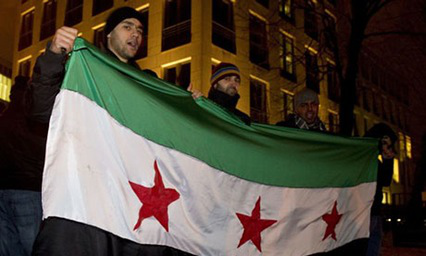

Caption:  British Muslims campaign outside the BBC headquarters in London against negative media portrayals of Muslims
Misinformation (Ground Truth): True
Associated summary:  SUMMARY:
             Germany is expelling four members of the Syrian Embassy in response to the arrest of two men accused of spying on Syrian opposition groups in Germany. The expulsion follows a meeting between the German Foreign Minister and the Syrian ambassador, during which the German government made clear its position against actions against Syrian opposition members. The move comes at a time when the Syrian government is facing international criticism for its brutal crackdown on anti-government protests. The suspects were accused of systematically gathering information on Syrian opposition groups in Germany for years. The Syrian government has been accused of seeking retribution against relatives of Syrian activists working against the al-Assad regime from abroad.
Model_prediction:  False
Model arguments:

In [18]:
incorrect_idx = get_incorrect_idx(result_data7, test_data_annotations)
#print(incorrect_idx)
failed_samples(incorrect_idx, result_data7)